In [ ]:
import pandas as pd

df_road_shape = pd.read_csv("/content/drive/MyDrive/Projects/DS201/data/q1_road_shape.csv")
df_traffic = pd.read_csv("/content/drive/MyDrive/Projects/DS201/data/q1_traffic.csv")

In [ ]:
df_road_shape.sample(2)

,segment_id,streetName,shape,connected_segment_ids
341,-17040019279711,Đường Hồ Tùng Mậu,"[(10.77235, 106.70368), (10.77298, 106.70336)]","[-17040019279711, -17040021223859, -1704001915..."
2935,17040024256469,Đường Võ Văn Kiệt,"[(10.75614, 106.6878), (10.75554, 106.68836)]","[17040018947142, 17040019598664, 1704001938282..."


In [ ]:
df_traffic.sample(2)

,segment_id,date,time,speedLimit,frc,streetName,shape,distance,segmentProbeCounts
1197417,17040023096403,2022-10-09,13:00 - 14:00,50,secondary road,Công Trường Lam Sơn,"[{'latitude': 10.77696, 'longitude': 106.70371...",33.53,5
735002,17040035094681,2022-10-19,7:00 - 8:00,50,major road,Đường Cách Mạng Tháng 8,"[{'latitude': 10.77367, 'longitude': 106.68942...",19.29,84


# ARIMA cho mọi đoạn đường

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def dynamic_forecast(road_df, p, d, q):
    predictions = []
    train, test = road_df.iloc[:400], road_df.iloc[400:]

    for i in tqdm(range(len(test))):
        model = ARIMA(train['density'], order=(p, d, q))
        fit_model = model.fit()

        pred = fit_model.forecast(steps=1)
        predictions.append(pred)
        train = train.append(test.iloc[i])

    return predictions, test, mean_squared_error(test["density"], predictions), r2_score(test["density"], predictions)

def get_start_time(time):
  return time[:time.index("-") - 1]

def to_sequences(dataset, seq_size=1):
    x = []
    y = []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
    return np.array(x),np.array(y)

In [ ]:
segments = df_traffic["segment_id"].unique()
segments

array([-17040019559514, -17040018864243, -17040020088759, ...,
        17040035666660,  17040035663318,  17040035034471])

In [ ]:
selected_segments = np.random.choice(segments, size=int(len(segments)*0.1))
selected_segments = np.array([-17040018864243])

In [ ]:
df_traffic['density'] = df_traffic['segmentProbeCounts'] / df_traffic['distance']
df_traffic['density']

0          0.092693
1          2.941176
2          0.574713
3          1.149264
4          1.217862
             ...   
2179195    0.186335
2179196    0.054358
2179197    2.143523
2179198    8.128079
2179199    0.008828
Name: density, Length: 2179200, dtype: float64

In [ ]:
import json
tmp = list(json.load(open("/content/drive/MyDrive/Projects/DS201/source_codes/lstm_losses.json")).keys())

In [ ]:
selected_segments = [int(i) for i in tmp]

# tìm p d q tối ưu

In [ ]:
import itertools
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

p = d = q = range(4, 7)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

AIC = []
parm_ = []
parm_s = []
param_i = 1
for param in pdq:
    print("TESTING PARAM #{}".format(param_i))
    for param_seasonal in tqdm(seasonal_pdq):
        try:
            mod = sm.tsa.statespace.SARIMAX(df_traffic_one['density'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            AIC.append(results.aic)
            parm_.append(param)
            parm_s.append(param_seasonal)

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
    param_i += 1

print(min(AIC))
pos = AIC.index(min(AIC))
print(parm_[pos])
print(parm_s[pos])

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (4, 4, 5) x (4, 4, 5, 12)
SARIMAX: (4, 4, 5) x (4, 4, 6, 12)
SARIMAX: (4, 4, 6) x (4, 5, 4, 12)
SARIMAX: (4, 4, 6) x (4, 5, 5, 12)
TESTING PARAM #1


  4%|▎         | 1/27 [06:46<2:56:17, 406.84s/it]

SARIMA(4, 4, 4)x(4, 4, 4, 12)12 - AIC:4525.715750694333


  7%|▋         | 2/27 [16:11<3:28:12, 499.68s/it]

SARIMA(4, 4, 4)x(4, 4, 5, 12)12 - AIC:4343.86062248455


 11%|█         | 3/27 [25:13<3:27:31, 518.81s/it]

SARIMA(4, 4, 4)x(4, 4, 6, 12)12 - AIC:4205.939017106701


 15%|█▍        | 4/27 [46:07<5:10:08, 809.08s/it]

SARIMA(4, 4, 4)x(4, 5, 4, 12)12 - AIC:5329.751979130431


 19%|█▊        | 5/27 [57:12<4:37:37, 757.14s/it]

SARIMA(4, 4, 4)x(4, 5, 5, 12)12 - AIC:4933.482343009262


 22%|██▏       | 6/27 [1:08:54<4:18:28, 738.50s/it]

SARIMA(4, 4, 4)x(4, 5, 6, 12)12 - AIC:4978.267597550381


 26%|██▌       | 7/27 [1:28:42<4:55:07, 885.35s/it]

SARIMA(4, 4, 4)x(4, 6, 4, 12)12 - AIC:5948.834751989217


 30%|██▉       | 8/27 [1:58:17<6:10:05, 1168.73s/it]

SARIMA(4, 4, 4)x(4, 6, 5, 12)12 - AIC:5734.040630516707


 33%|███▎      | 9/27 [2:14:09<5:30:13, 1100.77s/it]

SARIMA(4, 4, 4)x(4, 6, 6, 12)12 - AIC:5566.553992319024


 37%|███▋      | 10/27 [2:22:41<4:20:26, 919.18s/it]

SARIMA(4, 4, 4)x(5, 4, 4, 12)12 - AIC:4373.413461550766


 41%|████      | 11/27 [2:31:24<3:32:46, 797.92s/it]

SARIMA(4, 4, 4)x(5, 4, 5, 12)12 - AIC:4265.123063789135


 44%|████▍     | 12/27 [2:45:46<3:24:22, 817.47s/it]

SARIMA(4, 4, 4)x(5, 4, 6, 12)12 - AIC:4200.386310512082


 48%|████▊     | 13/27 [2:54:01<2:47:57, 719.82s/it]

SARIMA(4, 4, 4)x(5, 5, 4, 12)12 - AIC:5074.856231583982


 52%|█████▏    | 14/27 [3:17:43<3:21:51, 931.69s/it]

SARIMA(4, 4, 4)x(5, 5, 5, 12)12 - AIC:5174.404143915393


 59%|█████▉    | 16/27 [3:47:14<2:34:02, 840.23s/it] 

# train model

In [ ]:
!pip install shutup
import shutup
shutup.please()
import warnings
warnings.filterwarnings("ignore")

In [ ]:
selected_segments = np.array([-17040018864243])

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from math import sqrt

SEQ_SIZE = 1
FEATURE_SIZE = 32

for SEQ_SIZE in [10, 18, 24, 30]:
    losses = {}
    df_traffic["start_time"] = df_traffic["time"].apply(get_start_time)
    df_traffic["timstart_timee"] = pd.to_datetime(df_traffic["date"] + " " + df_traffic["start_time"])
    df_traffic["density"] = df_traffic["segmentProbeCounts"]/df_traffic["distance"]

    segment_i = 1
    for segment_id in selected_segments:
        print("TRAINING SEGMENT #{}".format(segment_i))
        df_traffic_tmp = df_traffic[df_traffic["segment_id"] == segment_id]
        df_traffic_tmp = df_traffic_tmp.sort_values("timstart_timee")
        df_traffic_tmp.reset_index(drop=True, inplace=True)

        #dataset = df_traffic_tmp["density"].values.reshape(-1, 1).astype("float32")
        #scaler = MinMaxScaler(feature_range=(0,1))
        #dataset = scaler.fit_transform(dataset)

        prediction, test, loss, r2 = dynamic_forecast(df_traffic_tmp, SEQ_SIZE, 1, SEQ_SIZE + 1)
        mae = mean_absolute_error(prediction, test["density"])
        print("{}->1: ".format(SEQ_SIZE),mae, " - ", loss, "-", r2)
        losses[segment_id] = {"mse_loss": loss, "r2_score": r2}
        segment_i += 1

TRAINING SEGMENT #1


100%|██████████| 80/80 [08:00<00:00,  6.00s/it]


10->1:  0.5231410338709759  -  0.44363373445167253 - 0.7853841588794195
TRAINING SEGMENT #1


100%|██████████| 80/80 [27:28<00:00, 20.61s/it]


18->1:  0.5254427045892976  -  0.42309082575351287 - 0.7953221624326616
TRAINING SEGMENT #1


100%|██████████| 80/80 [55:48<00:00, 41.86s/it]


24->1:  0.535688876357628  -  0.45572846008684087 - 0.7795331166485517
TRAINING SEGMENT #1


 32%|███▎      | 26/80 [27:58<58:00, 64.46s/it]

In [ ]:
# #biểu đồ độ fit của mô hình dự đoán so với ground truth của đoạn đường -17040021066708
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Ground Truth', marker='o')
plt.plot(predictions_original, label='Predictions', marker='o')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Ground Truth vs Predictions on Test Data')
plt.legend()
plt.show()

In [ ]:
import json
with open('/content/drive/MyDrive/Projects/DS201/source_codes/arima_results.json', 'w') as outfile:
  json.dump(dict((str(k), v) for k, v in losses.items()), outfile)

In [ ]:
df_traffic.sample()

,segment_id,date,time,speedLimit,frc,streetName,shape,distance,segmentProbeCounts,density,start_time,timstart_timee
1418982,17040018889198,2022-10-20,15:00 - 16:00,30,connecting road,Đường Trần Quang Khải,"[{'latitude': 10.79138, 'longitude': 106.68838...",99.41,93,0.93552,15:00,2022-10-20 15:00:00


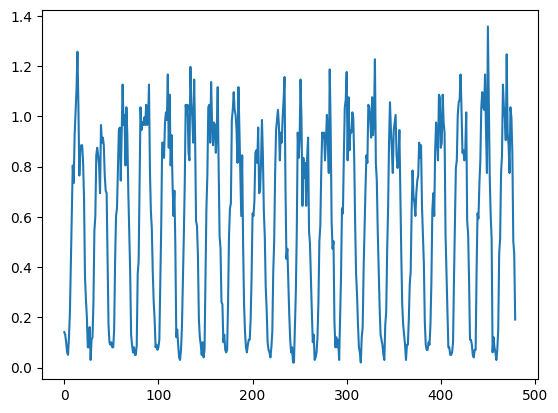

In [ ]:
df_traffic_one = df_traffic.sort_values("timstart_timee")
plt.plot(df_traffic_one[df_traffic_one["segment_id"] == 17040018889198]["density"].values)

In [ ]:
losses.items()

dict_items([(17040020242746, 1.402870300862045), (-17040020383702, 0.0012315961041556832), (17040019739523, 0.06290715723497457), (-17040022030830, 0.0004337857362753538), (17040018850590, 1.4120962883462336), (-17040020751776, 0.25362774446005293), (17040019143055, 0.2122041167202052), (-17040023096403, 0.01405576216589124), (17040018988944, 0.2276146957245296), (17040021374486, 4.0084086087266515), (17040021733225, 0.000831270115358887), (17040023088472, 1.156073264556952), (17040019037417, 29.447612876650663), (17040022873980, 0.10046214254964517)])

In [ ]:
df_traffic["start_time"] = df_traffic["time"].apply(get_start_time)
df_traffic["timstart_time"] = pd.to_datetime(df_traffic["date"] + " " + df_traffic["start_time"])
df_traffic["density"] = df_traffic["segmentProbeCounts"]/df_traffic["distance"]

In [ ]:
df_traffic_one = df_traffic[df_traffic["segment_id"] == 17040033537305]

In [ ]:
df_traffic_one = df_traffic_one.sort_values(by="timstart_time")
df_traffic_one.set_index("timstart_time", inplace=True)
df_traffic_one

,segment_id,date,time,speedLimit,frc,streetName,shape,distance,segmentProbeCounts,density,start_time
timstart_time,,,,,,,,,,,
2022-10-01 00:00:00,17040033537305,2022-10-01,0:00 - 1:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,77,9.517923,0:00
2022-10-01 01:00:00,17040033537305,2022-10-01,1:00 - 2:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,61,7.540173,1:00
2022-10-01 02:00:00,17040033537305,2022-10-01,2:00 - 3:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,56,6.922126,2:00
2022-10-01 03:00:00,17040033537305,2022-10-01,3:00 - 4:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,27,3.337454,3:00
2022-10-01 04:00:00,17040033537305,2022-10-01,4:00 - 5:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,29,3.584672,4:00
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 19:00:00,17040033537305,2022-10-20,19:00 - 20:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,477,58.961681,19:00
2022-10-20 20:00:00,17040033537305,2022-10-20,20:00 - 21:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,444,54.882571,20:00
2022-10-20 21:00:00,17040033537305,2022-10-20,21:00 - 22:00,50,connecting road,Đường Nam Kỳ Khởi Nghĩa,"[{'latitude': 10.77776, 'longitude': 106.69696...",8.09,380,46.971570,21:00


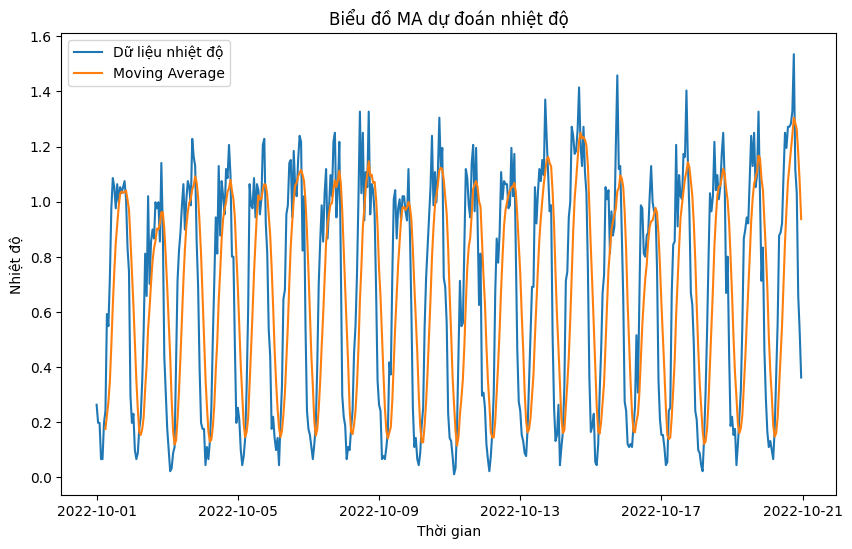

In [ ]:
window_size = 7
ma = df_traffic_one[["density"]].rolling(window_size).mean()
plt.figure(figsize=(10, 6))
plt.plot(df_traffic_one.index, df_traffic_one[["density"]], label='Dữ liệu nhiệt độ')
plt.plot(df_traffic_one.index, ma, label='Moving Average')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ')
plt.title('Biểu đồ MA dự đoán nhiệt độ')
plt.legend()
plt.show()

In [ ]:
train_size = int(len(df_traffic_one) * 0.8)
train, test = df_traffic_one.iloc[:train_size], df_traffic_one.iloc[train_size:]

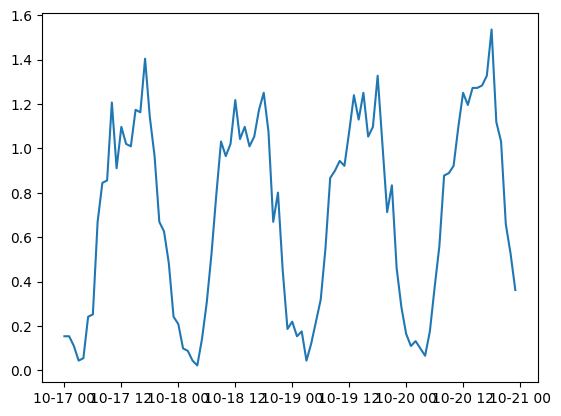

In [ ]:
plt.plot(test['density'])

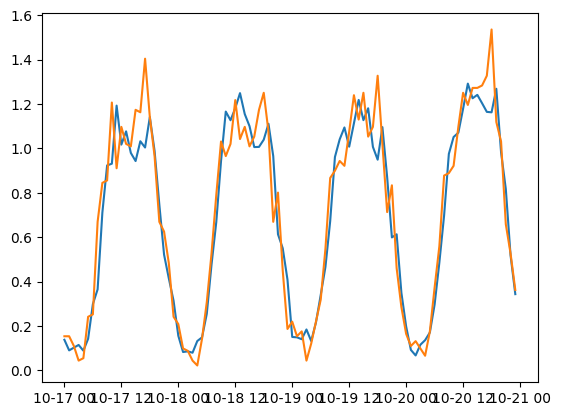

In [ ]:
plt.plot(test.index, predictions)
plt.plot(test['density'])

In [ ]:
!pip install shutup
import shutup
shutup.please()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

100%|██████████| 96/96 [04:21<00:00,  2.73s/it]


TypeError: bad operand type for unary +: 'list'

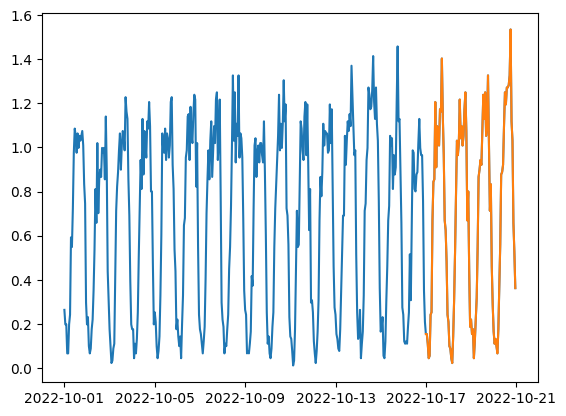

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def dynamic_forecast(road_df, p, d, q):
    predictions = []
    train_size = int(len(road_df) * 0.8)
    train, test = road_df.iloc[:train_size], road_df.iloc[train_size:]

    for i in tqdm(range(len(test))):
        model = ARIMA(train['density'], order=(p, d, q))
        fit_model = model.fit()

        pred = fit_model.forecast(steps=1)
        predictions.append(pred)

        return predictions, mean_squared_error(test["density"], predictions[:-1])
        #train = train.append(test.iloc[i])

    # plt.plot(train['density'], label='Training Data')
    # plt.plot(test['density'], label='Test Data')
    # plt.plot(test.index, predictions, label='ARIMA Predictions')
    # plt.title(f'Road {road_df["segment_id"].iloc[0]} - Dynamic Forecasting')
    # plt.legend()
    # plt.show()

# grouped_df = df_traffic.groupby('segment_id')
# for road_id, road_data in grouped_df:
#     dynamic_forecast(road_data, p=5, d=1, q=2)
dynamic_forecast(df_traffic_one, 5, 1, 6)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mae = mean_absolute_error(test["density"], prediction)
mse = mean_squared_error(test["density"], prediction)
r2 = r2_score(test["density"], prediction)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

MAE: 0.85261502617472
MSE: 1.2764442337466195
R2: 0.7087982810620301


In [ ]:
test.reset_index(drop=True, inplace=True)

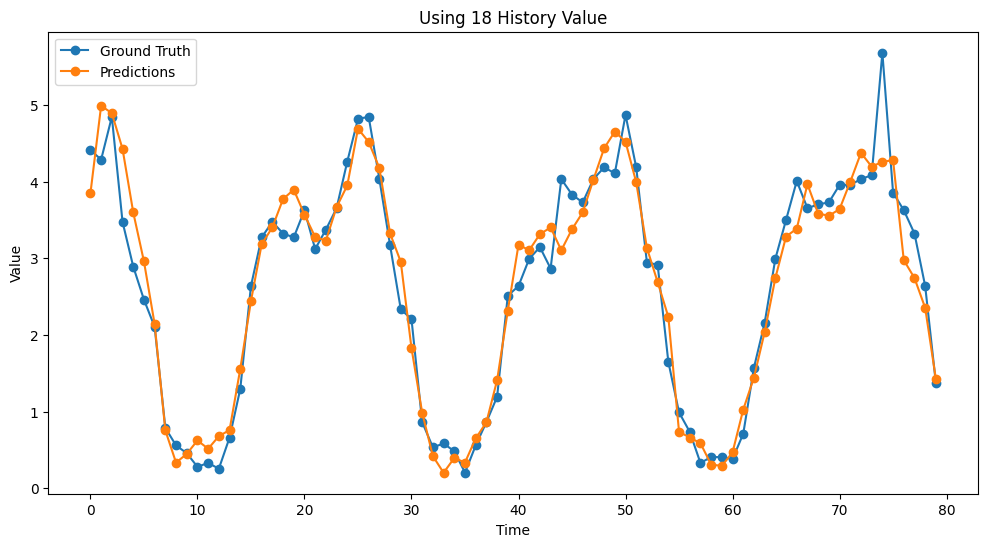

In [ ]:
# #biểu đồ độ fit của mô hình dự đoán so với ground truth của đoạn đường -17040021066708
#predictions = model.predict(X_test)
#predictions_original = scaler.inverse_transform(predictions)
#y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(test["density"], label='Ground Truth', marker='o')
plt.plot(prediction, label='Predictions', marker='o')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Using 18 History Value')
plt.legend()
plt.show()